<a href="https://colab.research.google.com/github/AbbanapuramRamyaSri/23CSBTB30/blob/main/NLP%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# ============================================================
# 🍴 NLP Project – Recipes Dataset | Assignments 1 → 6
# ============================================================

# ▶ Import libraries
import re, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
warnings.filterwarnings("ignore")
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models
import spacy
import nltk
nltk.download('stopwords')

# ▶ Load dataset
from google.colab import files
# Upload your recipes.csv file manually
uploaded = files.upload()

# Correct the filename based on the uploaded file
df = pd.read_csv("/content/recipes (1).csv")
print("✅ Loaded:", df.shape)
df.head()

# Detect text column automatically
possible_text_cols = ['instructions','instruction','recipe','ingredients','text','description','directions']
text_col = next((c for c in df.columns if c.lower() in possible_text_cols), None)
if not text_col:
    text_col = df.select_dtypes('object').columns[0]
print("Using text column:", text_col)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving recipes.csv to recipes (8).csv
✅ Loaded: (1090, 15)
Using text column: ingredients



🧹 Sample cleaned text:


,ingredients,clean_text
0,"3 tablespoons butter, 2 pounds Granny Smith ap...",tablespoons butter pounds granny smith apples ...
1,"8 small Granny Smith apples, or as needed, ½ c...",small granny smith apples or as needed cup uns...
2,"4 apples - peeled, cored and chopped, ¾ cup w...",apples peeled cored and chopped cup water cup ...


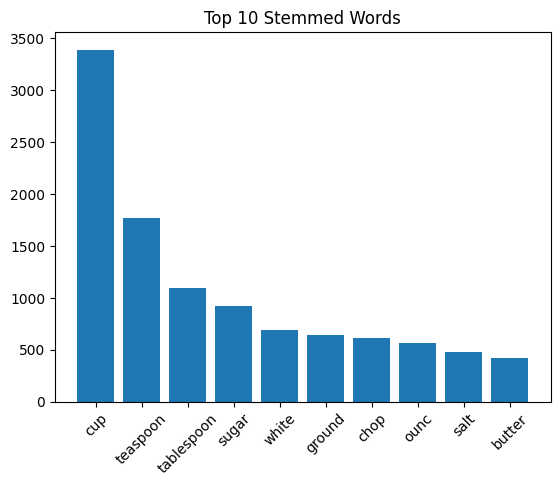

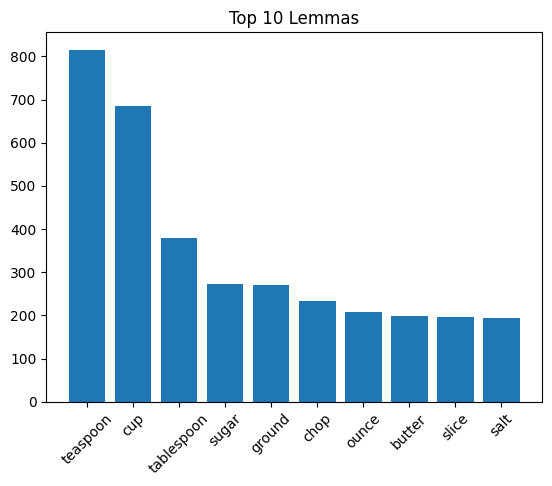

In [13]:
# ============================================================
# ASSIGNMENT 1 — Cleaning, Tokenizing, Stemming, Lemmatizing
# ============================================================

ps = PorterStemmer()
nlp = spacy.load("en_core_web_sm")
STOPWORDS = set(stopwords.words('english'))

def clean_text(s):
    s = re.sub(r'\n|\r', ' ', str(s))
    s = re.sub(r'http\S+|www\.\S+', ' ', s)
    s = re.sub(r'\S+@\S+', ' ', s)
    s = re.sub(r'[^A-Za-z\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip().lower()
    return s

df['clean_text'] = df[text_col].map(clean_text)
print("\n🧹 Sample cleaned text:")
display(df[[text_col, 'clean_text']].head(3))

def tokenize_stem(text):
    toks = [w for w in re.findall(r'\b[a-z]{2,}\b', text.lower()) if w not in STOPWORDS]
    stems = [ps.stem(w) for w in toks]
    return stems

stems_all = sum(df['clean_text'].apply(tokenize_stem).tolist(), [])
top10_stems = Counter(stems_all).most_common(10)
plt.bar(*zip(*top10_stems)); plt.title("Top 10 Stemmed Words"); plt.xticks(rotation=45); plt.show()

lemmas_all = []
for doc in nlp.pipe(df['clean_text'].iloc[:500], disable=["ner","parser"]):
    lemmas_all += [t.lemma_.lower() for t in doc if t.is_alpha and t.pos_ in {"NOUN","VERB"}]
top10_lemmas = Counter(lemmas_all).most_common(10)
plt.bar(*zip(*top10_lemmas)); plt.title("Top 10 Lemmas"); plt.xticks(rotation=45); plt.show()



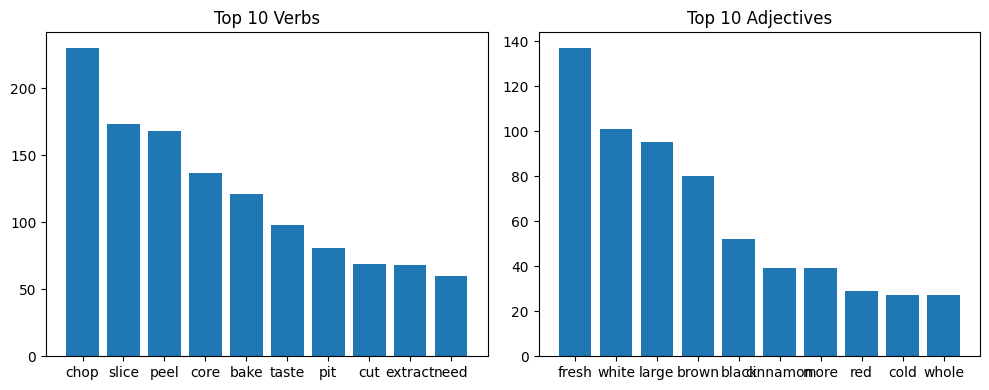

In [14]:
# ============================================================
# ASSIGNMENT 2 — POS Tagging & Visualization
# ============================================================
verbs, adjs = [], []
for doc in nlp.pipe(df['clean_text'].iloc[:500], disable=["ner","parser"]):
    verbs += [t.lemma_.lower() for t in doc if t.pos_=="VERB"]
    adjs  += [t.lemma_.lower() for t in doc if t.pos_=="ADJ"]

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].bar(*zip(*Counter(verbs).most_common(10))); ax[0].set_title("Top 10 Verbs")
ax[1].bar(*zip(*Counter(adjs).most_common(10)));  ax[1].set_title("Top 10 Adjectives")
plt.tight_layout(); plt.show()


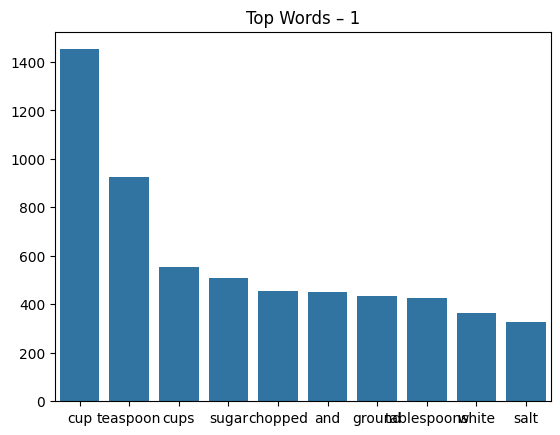

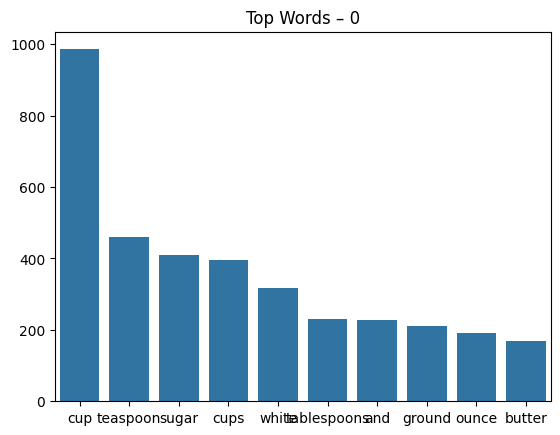

Vocabulary size: 5000
Sample bigrams: ['tablespoons butter', 'butter pounds', 'pounds granny', 'granny smith', 'smith apples', 'apples or', 'or other', 'other firm', 'firm crisp', 'crisp apples']


In [17]:
# ============================================================
# ASSIGNMENT 3 — Corpus & Feature Analysis
# ============================================================
cat_col = next((c for c in df.columns if c.lower() in ['cuisine','type','category','dish_type']), None)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

if cat_col:
    df.groupby(cat_col)['word_count'].mean().plot(kind='bar', title="Average Text Length per Category", figsize=(8,4))
    plt.show()
else:
    df['label_len'] = (df['word_count'] > df['word_count'].median()).astype(int)
    cat_col = 'label_len'

for c in df[cat_col].unique()[:3]:
    txt = " ".join(df.loc[df[cat_col]==c,'clean_text'])
    top = Counter(txt.split()).most_common(10)
    sns.barplot(x=[v for v, w in top], y=[w for v, w in top])
    plt.title(f"Top Words – {c}")
    plt.show()

vec = CountVectorizer(ngram_range=(1,2), max_features=5000)
X_counts = vec.fit_transform(df['clean_text'])
print("Vocabulary size:", len(vec.vocabulary_))
print("Sample bigrams:", [k for k in vec.vocabulary_ if ' ' in k][:10])

In [19]:

# ASSIGNMENT 4 — Classical ML Models
# ============================================================
y = df[cat_col].astype(str)
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=8000)
X = tfidf.fit_transform(df['clean_text'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models_dict = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "LinearSVC": LinearSVC(max_iter=2000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models_dict.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = {
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds, average="weighted", zero_division=0),
        "recall": recall_score(y_test, preds, average="weighted", zero_division=0),
        "f1": f1_score(y_test, preds, average="weighted", zero_division=0)
    }
display(pd.DataFrame(results).T)



,accuracy,precision,recall,f1
LogisticRegression,0.793578,0.799197,0.793578,0.791398
LinearSVC,0.816514,0.819314,0.816514,0.815388
RandomForest,0.899083,0.899997,0.899083,0.898852


In [20]:
# ============================================================
# ASSIGNMENT 5 — Deep Learning Models (MLP, CNN, LSTM)
# ============================================================
y_train_int = pd.factorize(y_train)[0]
y_test_int  = pd.factorize(y_test)[0]

# --- MLP ---
model_mlp = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(set(y)), activation='softmax')
])
model_mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_mlp.fit(X_train.toarray(), y_train_int, epochs=3, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5878 - loss: 0.6861 - val_accuracy: 0.8295 - val_loss: 0.6421
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8672 - loss: 0.5935 - val_accuracy: 0.8068 - val_loss: 0.5536
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9052 - loss: 0.4445 - val_accuracy: 0.8295 - val_loss: 0.4661


In [26]:
# --- Tokenize for CNN/LSTM ---
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
seqs = tokenizer.texts_to_sequences(df['clean_text'])
X_pad = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=100)

# Create integer labels for the whole dataset
y_int = pd.factorize(y)[0]

# Split the padded sequences and integer labels
Xtr, Xte, ytr, yte = train_test_split(X_pad, y_int, test_size=0.2, random_state=42, stratify=y_int)

In [29]:
# --- CNN ---
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Step 1: Pad input sequences
Xtr = pad_sequences(Xtr, maxlen=100)
Xtr = np.array(Xtr, dtype=np.int32)

# Step 2: Encode labels
le = LabelEncoder()
ytr = le.fit_transform(ytr)
ytr = np.array(ytr, dtype=np.int32)

# Step 3: Define CNN model
model_cnn = models.Sequential([
    layers.Embedding(input_dim=10000, output_dim=64, input_length=100),
    layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(ytr)), activation='softmax')
])

# Step 4: Compile and train
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn.fit(Xtr, ytr, epochs=3, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5625 - loss: 0.6832 - val_accuracy: 0.8068 - val_loss: 0.6399
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8371 - loss: 0.5888 - val_accuracy: 0.7955 - val_loss: 0.5240
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8927 - loss: 0.4078 - val_accuracy: 0.8068 - val_loss: 0.4242


In [30]:
# --- LSTM ---
model_lstm = models.Sequential([
    layers.Embedding(10000, 64, input_length=100),
    layers.LSTM(64),
    layers.Dense(len(set(y)), activation='softmax')
])
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_lstm.fit(Xtr, ytr, epochs=3, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6193 - loss: 0.6310 - val_accuracy: 0.8864 - val_loss: 0.2985
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9250 - loss: 0.2055 - val_accuracy: 0.9545 - val_loss: 0.0920
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9974 - loss: 0.0522 - val_accuracy: 0.9886 - val_loss: 0.0459


In [32]:
# ============================================================
# ASSIGNMENT 6 — N-gram Comparison
# ============================================================
def train_ngram(n_range):
    vec = TfidfVectorizer(ngram_range=n_range, max_features=5000)
    Xv = vec.fit_transform(df['clean_text'])
    Xtr, Xte, ytr, yte = train_test_split(Xv, y_int, test_size=0.2, random_state=42, stratify=y_int)
    lr = LogisticRegression(max_iter=500)
    lr.fit(Xtr, ytr)
    preds = lr.predict(Xte)
    return {
        "accuracy": accuracy_score(yte, preds),
        "precision": precision_score(yte, preds, average='weighted', zero_division=0),
        "recall": recall_score(yte, preds, average='weighted', zero_division=0),
        "f1": f1_score(yte, preds, average='weighted', zero_division=0)
    }

ngram_results = {
    "Unigram (1,1)": train_ngram((1,1)),
    "Bigram (1,2)": train_ngram((1,2)),
    "Trigram (1,3)": train_ngram((1,3))
}
display(pd.DataFrame(ngram_results).T)

,accuracy,precision,recall,f1
"Unigram (1,1)",0.724771,0.724567,0.724771,0.724608
"Bigram (1,2)",0.747706,0.747589,0.747706,0.747252
"Trigram (1,3)",0.811927,0.811858,0.811927,0.811875
